# Plot and average responses

Found groups: {'bpf_ctrl_1;-1;1': ['bpf_ctrl/audio/bpf_ctrl_1;-1;1_1.wav', 'bpf_ctrl/audio/bpf_ctrl_1;-1;1_2.wav', 'bpf_ctrl/audio/bpf_ctrl_1;-1;1_3.wav'], 'bpf_ctrl_1;-1.5;-1.5': ['bpf_ctrl/audio/bpf_ctrl_1;-1.5;-1.5_3.wav', 'bpf_ctrl/audio/bpf_ctrl_1;-1.5;-1.5_2.wav', 'bpf_ctrl/audio/bpf_ctrl_1;-1.5;-1.5_1.wav'], 'bpf_ctrl_off': ['bpf_ctrl/audio/bpf_ctrl_off_2.wav', 'bpf_ctrl/audio/bpf_ctrl_off_3.wav', 'bpf_ctrl/audio/bpf_ctrl_off_1.wav'], 'bpf_ctrl_0;-3;0': ['bpf_ctrl/audio/bpf_ctrl_0;-3;0_2.wav', 'bpf_ctrl/audio/bpf_ctrl_0;-3;0_3.wav', 'bpf_ctrl/audio/bpf_ctrl_0;-3;0_1.wav']}

Processing group bpf_ctrl_1;-1;1 with files: ['bpf_ctrl/audio/bpf_ctrl_1;-1;1_1.wav', 'bpf_ctrl/audio/bpf_ctrl_1;-1;1_2.wav', 'bpf_ctrl/audio/bpf_ctrl_1;-1;1_3.wav']


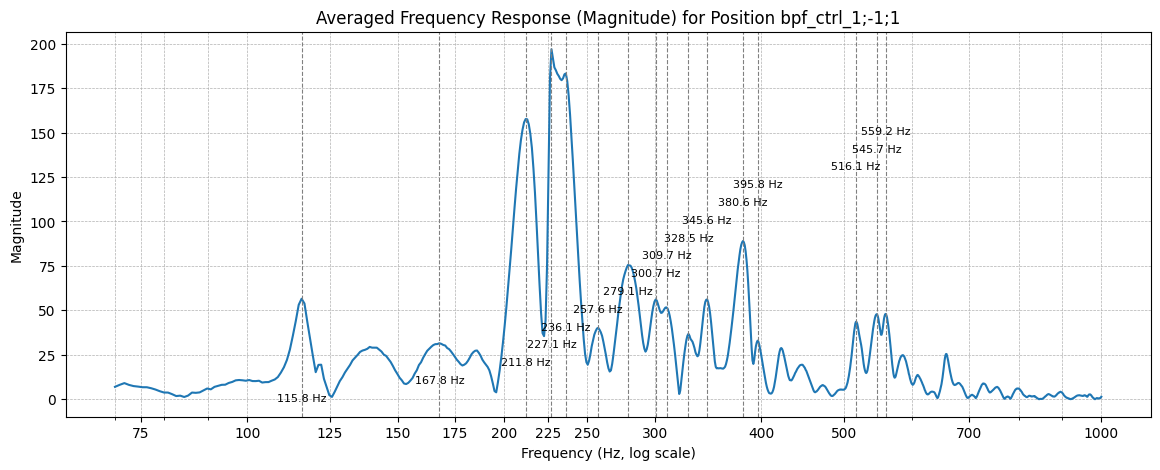


Processing group bpf_ctrl_1;-1.5;-1.5 with files: ['bpf_ctrl/audio/bpf_ctrl_1;-1.5;-1.5_3.wav', 'bpf_ctrl/audio/bpf_ctrl_1;-1.5;-1.5_2.wav', 'bpf_ctrl/audio/bpf_ctrl_1;-1.5;-1.5_1.wav']


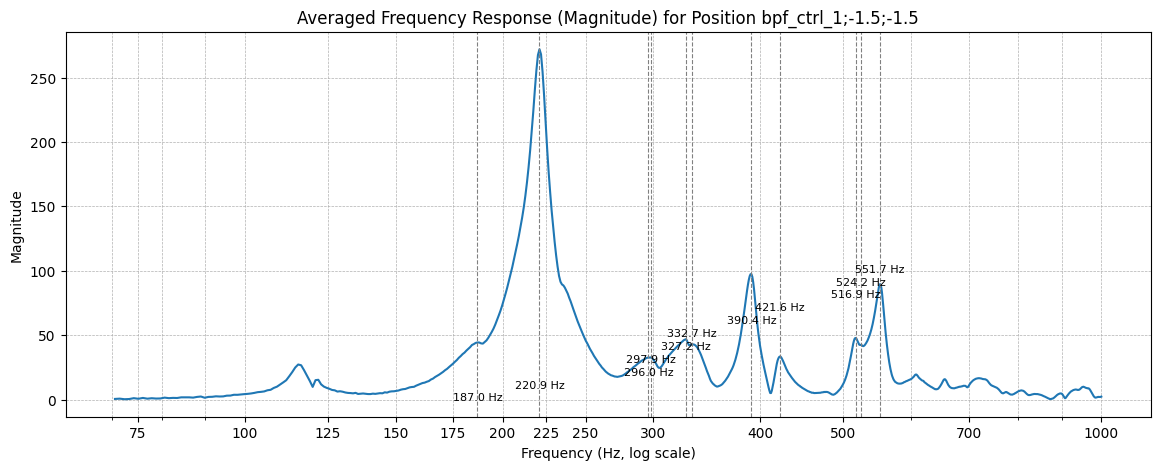


Processing group bpf_ctrl_off with files: ['bpf_ctrl/audio/bpf_ctrl_off_2.wav', 'bpf_ctrl/audio/bpf_ctrl_off_3.wav', 'bpf_ctrl/audio/bpf_ctrl_off_1.wav']


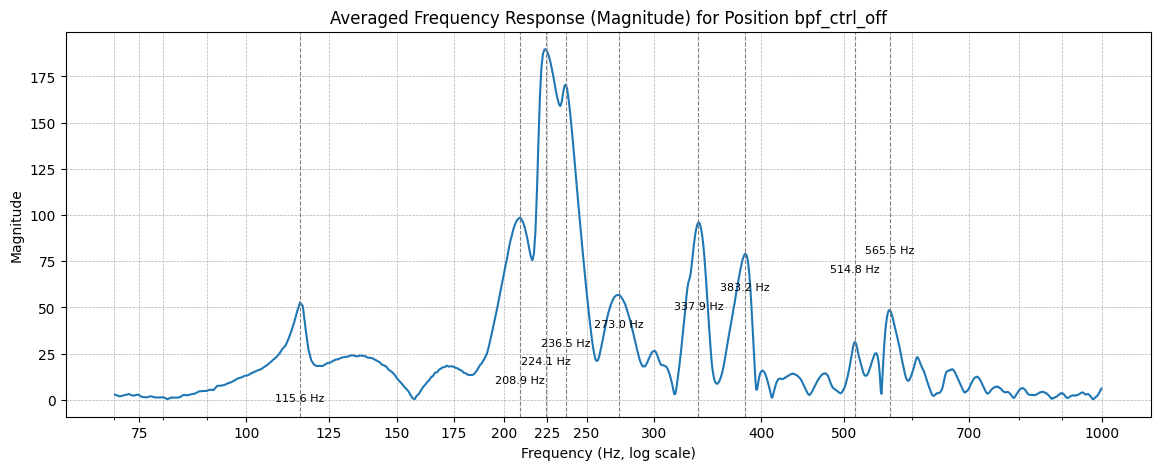


Processing group bpf_ctrl_0;-3;0 with files: ['bpf_ctrl/audio/bpf_ctrl_0;-3;0_2.wav', 'bpf_ctrl/audio/bpf_ctrl_0;-3;0_3.wav', 'bpf_ctrl/audio/bpf_ctrl_0;-3;0_1.wav']


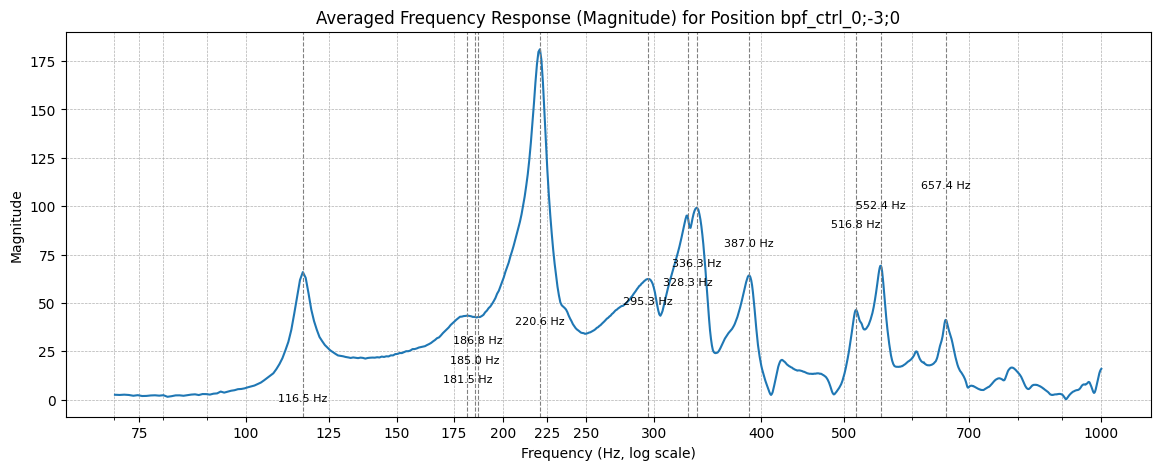

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import glob
import re
import os

import scipy.signal

folder = 'bpf_ctrl/audio'
save_dir = 'bpf_ctrl/plots/'
os.makedirs(save_dir, exist_ok=True)

files = glob.glob(os.path.join(folder, '*.wav'))
groups = {}
pattern = re.compile(r'([\w\-\.;]+)_\d\.wav')
for file in files:
    basename = os.path.basename(file)
    match = pattern.match(basename)
    if match:
        n = match.group(1)
        groups.setdefault(n, []).append(file)

print("Found groups:", groups)

epsilon = 1e-10  # small value to avoid log(0)

for n, file_list in groups.items():
    print(f"\nProcessing group {n} with files: {file_list}")
    avg_fft = None
    count = 0
    max_length = max([len(librosa.load(file, sr=None)[0]) for file in file_list])
    
    for file in file_list:
        y, sr = librosa.load(file, sr=None)
        
        if np.max(np.abs(y)) > 0:
            y = y / np.max(np.abs(y))
        if len(y) < max_length:
            y = np.pad(y, (0, max_length - len(y)), mode='constant')
        else:
            y = y[:max_length]
        fft_vals = np.fft.fft(y)
        if avg_fft is None:
            avg_fft = np.zeros_like(fft_vals, dtype=complex)
        avg_fft += fft_vals
        count += 1

    avg_fft /= count
    fft_freq = np.fft.fftfreq(len(avg_fft), 1/sr)
    mask = fft_freq > 20
    fft_freq_pos = fft_freq[mask]
    fft_mag = np.abs(avg_fft[mask])
    fft_db = 20 * np.log10(fft_mag + epsilon)
    fft_db = fft_mag
    peaks = scipy.signal.find_peaks(fft_db, height=30)

    plt.figure(figsize=(14, 5))
    freq_range_mask = (fft_freq_pos >= 70) & (fft_freq_pos <= 1000)
    plt.plot(fft_freq_pos[freq_range_mask], fft_db[freq_range_mask])
    # plt.plot(fft_freq_pos, fft_db)
    plt.xscale('log')
    plt.title(f"Averaged Frequency Response (Magnitude) for Position {n}")
    plt.xlabel("Frequency (Hz, log scale)")
    plt.ylabel("Magnitude")
    plt.grid(True, which="both", ls="--", lw=0.5)
    count = 0
    for peak_idx in peaks[0]:
        peak_freq = fft_freq_pos[peak_idx]
        plt.axvline(x=peak_freq, color='grey', linestyle='--', linewidth=0.8)
        plt.text(peak_freq, count * 10 - 1, f"{peak_freq:.1f} Hz", color='black', fontsize=8, ha='center')
        count += 1

    reference_ticks = [ 75, 100, 125, 150, 175, 200, 225, 250, 300, 400, 500, 700, 1000]
    plt.xticks(reference_ticks, reference_ticks)

    magnitude_filename = os.path.join(save_dir, f"freq_response_position_{n}.png")
    # plt.savefig(magnitude_filename, dpi=300, bbox_inches='tight')
    plt.show()
    

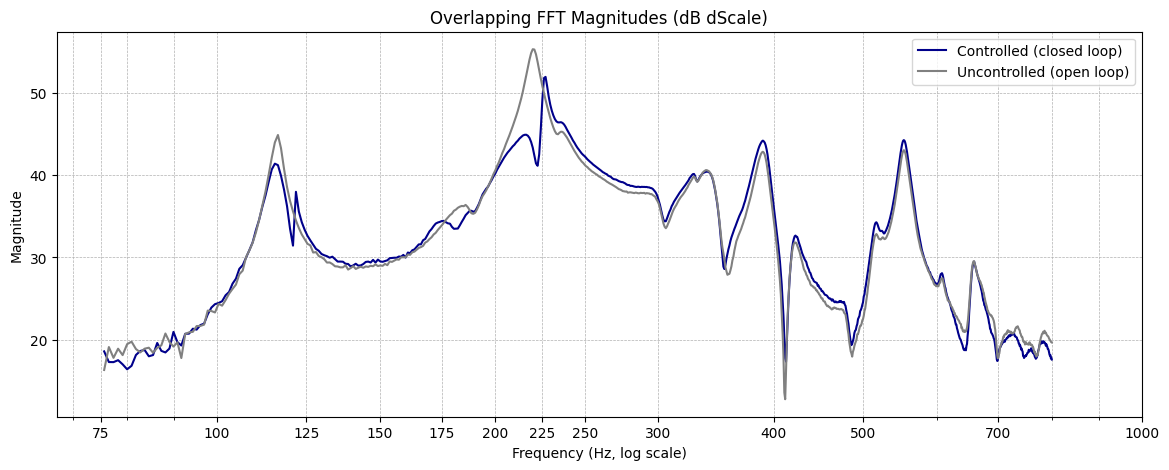

In [ ]:
def to_db(x):
    return 20 * np.log10(x + 1e-10)

control_response = 'bpf_ctrl/audio/bpf_ctrl_1;-1;1_1.wav'
open_response = 'bpf_ctrl/audio/bpf_ctrl_off_3.wav'
y_control, sr1 = librosa.load(control_response, sr=None)
y_open, sr2 = librosa.load(open_response, sr=None)
assert sr1 == sr2, "Sampling rates of the two files must be the same."

y_open = y_open / np.max(np.abs(y_open))
y_control = y_control / np.max(np.abs(y_control))

max_length = max(len(y_control), len(y_open))
y_control = np.pad(y_control, (0, max_length - len(y_control)), mode='constant')
y_open = np.pad(y_open, (0, max_length - len(y_open)), mode='constant')

fft_vals_control = np.fft.fft(y_control)
fft_vals_open = np.fft.fft(y_open)
fft_mag_control = to_db(np.abs(fft_vals_control))
fft_mag_open = to_db(np.abs(fft_vals_open))
fft_freq = np.fft.fftfreq(max_length, 1/sr1)

mask = (fft_freq > 75) & (fft_freq <= 800)
fft_freq_pos = fft_freq[mask]
fft_mag_control_pos = fft_mag_control[mask]
fft_mag_open_pos = fft_mag_open[mask]

plt.figure(figsize=(14, 5))
plt.plot(fft_freq_pos, fft_mag_control_pos, label='Controlled (closed loop)', color='darkblue')
plt.plot(fft_freq_pos, fft_mag_open_pos, label='Uncontrolled (open loop)', color='gray')
plt.xscale('log')
plt.title("Overlapping FFT Magnitudes (dB Scale)")
plt.xlabel("Frequency (Hz, log scale)")
plt.ylabel("Magnitude")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
reference_ticks = [ 75, 100, 125, 150, 175, 200, 225, 250, 300, 400, 500, 700, 1000]
plt.xticks(reference_ticks, reference_ticks)
plt.show()

# Essentially the same script as before, except that it avereages across measurements

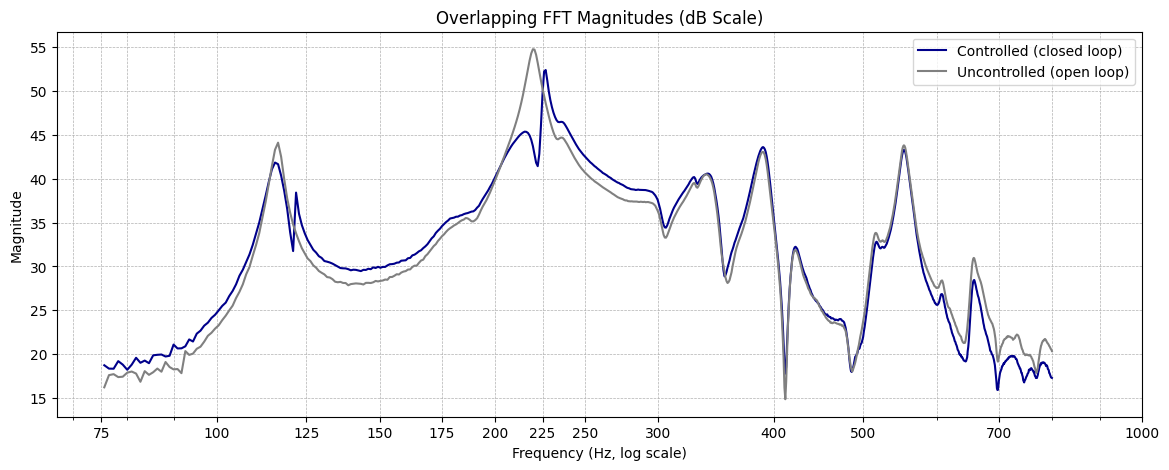

In [33]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def load_and_normalize(fns, sr=None):
    ys = []
    for fn in fns:
        y, sr = librosa.load(fn, sr=sr)
        ys.append(y / np.max(np.abs(y)))
    return ys, sr

ctrl = [f'bpf_ctrl/audio/bpf_ctrl_1;-1;1_{i}.wav' for i in (1,2,3)]
open_ = [f'bpf_ctrl/audio/bpf_ctrl_off_{i}.wav' for i in (1,2,3)]
all_fns = ctrl + open_

all_waves, sr = load_and_normalize(all_fns, sr=None)
N_global = max(len(y) for y in all_waves)

def avg_fft_mag(fns, sr, N):
    ys, _ = load_and_normalize(fns, sr=sr)
    ys = [np.pad(y, (0, N-len(y)), 'constant') for y in ys]
    mags = [np.abs(np.fft.rfft(y)) for y in ys]
    mean_mag = np.mean(mags, axis=0)
    return mean_mag

mag_ctrl = avg_fft_mag(ctrl, sr, N_global)
mag_open = avg_fft_mag(open_, sr, N_global)
freqs    = np.fft.rfftfreq(N_global, 1/sr)

mask = (freqs > 75) & (freqs <= 800)
f    = freqs[mask]
c_db = 20*np.log10(mag_ctrl[mask] + 1e-10)
o_db = 20*np.log10(mag_open[mask] + 1e-10)

plt.figure(figsize=(14,5))
plt.plot(f, c_db,  label='Controlled (closed loop)',   color='darkblue')
plt.plot(f, o_db,  label='Uncontrolled (open loop)', color='gray')
plt.xscale('log')
plt.title("Overlapping FFT Magnitudes (dB Scale)")
plt.xlabel("Frequency (Hz, log scale)")
plt.ylabel("Magnitude")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.xticks([75,100,125,150,175,200,225,250,300,400,500,700,1000],
           [75,100,125,150,175,200,225,250,300,400,500,700,1000])
plt.show()


# Using PSD (welch) (run the above script first)

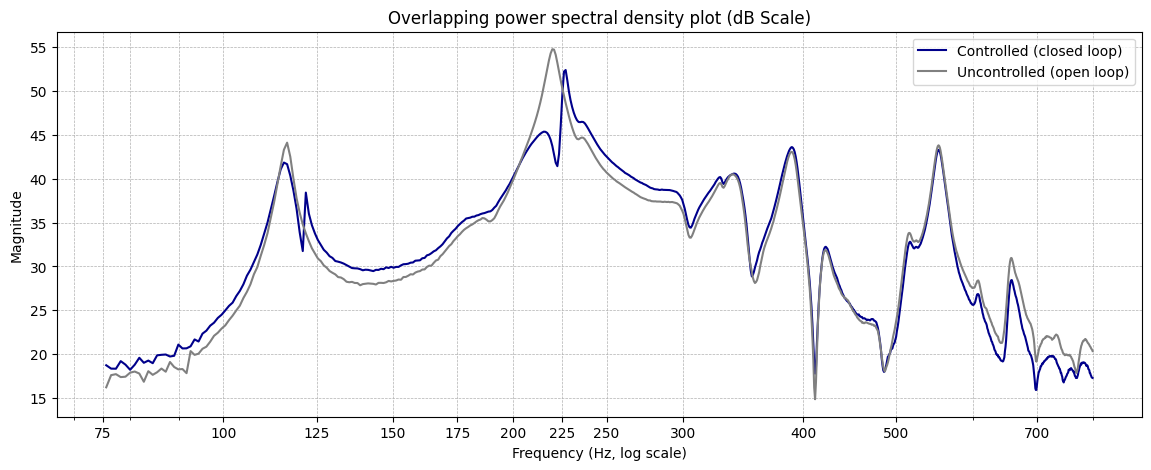

In [22]:
from scipy.signal import welch
import numpy as np
import librosa

def average_psd(file_list, sr=None, nperseg=1024):
    psds = []
    for fn in file_list:
        y, sr = librosa.load(fn, sr=sr)
        y /= np.max(np.abs(y))
        f, Pxx = welch(y, sr, nperseg=nperseg)
        psds.append(Pxx)
    return f, np.mean(psds, axis=0)

f, P_ctrl = average_psd(ctrl, sr)
_,   P_open = average_psd(open_, sr)


C = 10*np.log10(P_ctrl)
O = 10*np.log10(P_open)

mask = (freqs > 75) & (freqs <= 800)
f    = freqs[mask]
c_db = 20*np.log10(mag_ctrl[mask] + 1e-10)
o_db = 20*np.log10(mag_open[mask] + 1e-10)

plt.figure(figsize=(14,5))
plt.plot(f, c_db,  label='Controlled (closed loop)',   color='darkblue')
plt.plot(f, o_db,  label='Uncontrolled (open loop)', color='gray')
plt.xscale('log')
plt.title("Overlapping power spectral density plot (dB Scale)")
plt.xlabel("Frequency (Hz, log scale)")
plt.ylabel("Magnitude")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.xticks([75,100,125,150,175,200,225,250,300,400,500,700],
           [75,100,125,150,175,200,225,250,300,400,500,700])
plt.show()


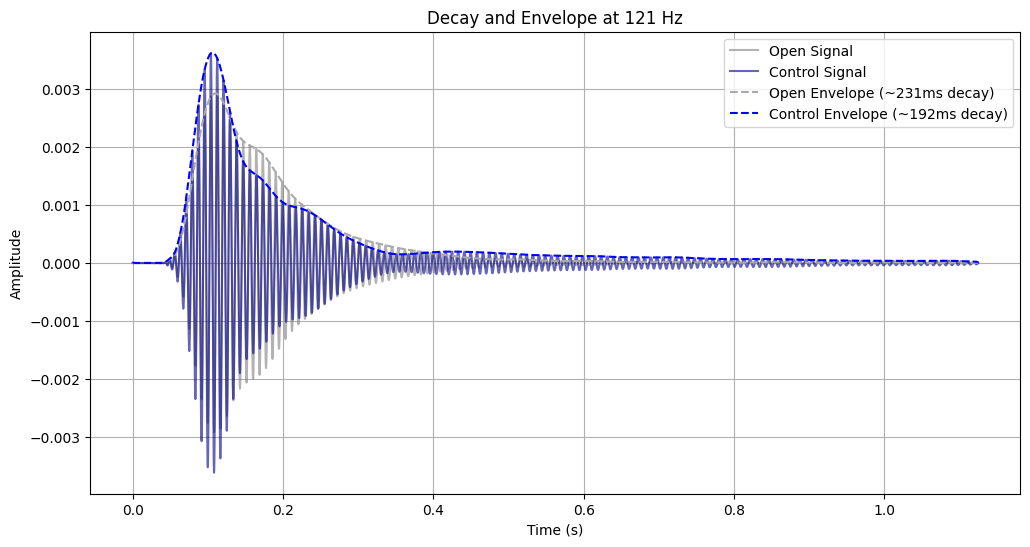

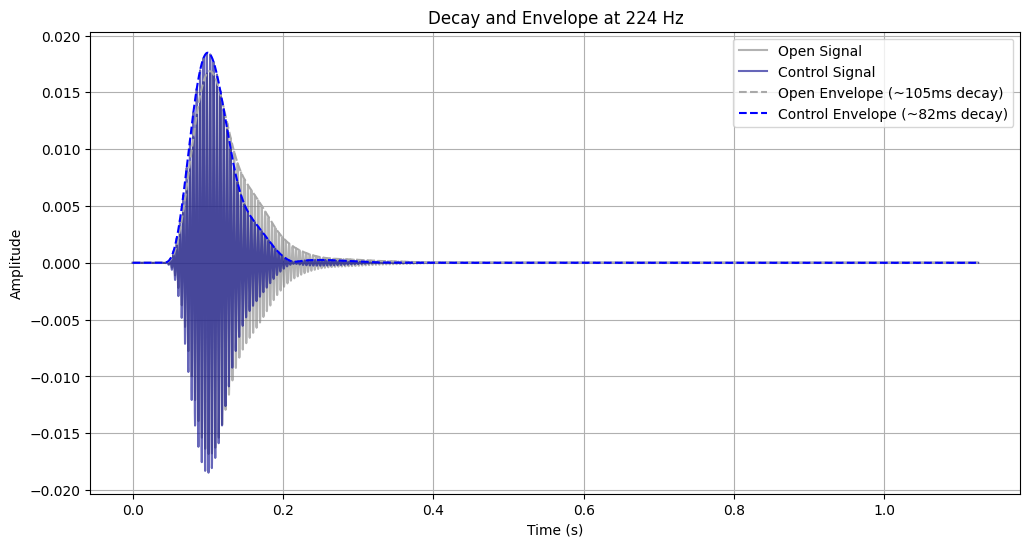

In [ ]:
import numpy as np
import librosa
import scipy.signal
import matplotlib.pyplot as plt

def normalize_audio(audio):
    if np.max(np.abs(audio)) > 0:
        return audio / np.max(np.abs(audio))
    return audio

def align_signals(sig1, sig2):
    """Aligns sig2 to sig1 based on cross-correlation."""
    correlation = scipy.signal.correlate(sig1, sig2, mode='full')
    lag = np.argmax(correlation) - len(sig2) + 1

    if lag > 0:
        aligned_sig2 = np.pad(sig2, (lag, 0), mode='constant')[:len(sig1)]
    else:
        aligned_sig2 = sig2[-lag:]  # Shift left
        if len(aligned_sig2) < len(sig1):
            aligned_sig2 = np.pad(aligned_sig2, (0, len(sig1) - len(aligned_sig2)), mode='constant')

    return aligned_sig2

def plot_decay_and_envelope(y_open, y_control, sr, resonance_freqs, bandwidth=10):
    time = np.arange(len(y_open)) / sr 
    
    for freq in resonance_freqs:
        # Bandpass filter for the selected frequency
        sos = scipy.signal.butter(4, [freq - bandwidth, freq + bandwidth], btype='band', fs=sr, output='sos')
        filtered_open = scipy.signal.sosfilt(sos, y_open)
        filtered_control = scipy.signal.sosfilt(sos, y_control)
        
        envelope_open = np.abs(scipy.signal.hilbert(filtered_open))
        envelope_control = np.abs(scipy.signal.hilbert(filtered_control))

        peak_idx_open = np.argmax(envelope_open)
        peak_idx_control = np.argmax(envelope_control)
        
        threshold_open = 0.1 * envelope_open[peak_idx_open]
        threshold_control = 0.1 * envelope_control[peak_idx_control]
        
        decay_idx_open = next((i for i in range(peak_idx_open, len(envelope_open)) 
                               if envelope_open[i] < threshold_open), len(envelope_open)-1)
        decay_idx_control = next((i for i in range(peak_idx_control, len(envelope_control)) 
                                  if envelope_control[i] < threshold_control), len(envelope_control)-1)
        
        decay_time_open = round((time[decay_idx_open] - time[peak_idx_open])* 1000)   # Convert to ms
        decay_time_control = round((time[decay_idx_control] - time[peak_idx_control]) * 1000)   # Convert to ms

        plt.figure(figsize=(12, 6))
        plt.plot(time, filtered_open, label=f'Open Signal', alpha=0.6, color='gray')
        plt.plot(time, filtered_control, label=f'Control Signal', alpha=0.6, color='darkblue')
        plt.plot(time, envelope_open, label=f'Open Envelope (~{decay_time_open}ms decay)', linestyle='--', color='darkgray')
        plt.plot(time, envelope_control, label=f'Control Envelope (~{decay_time_control}ms decay)', linestyle='--', color='blue')
        plt.title(f"Decay and Envelope at {freq} Hz")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid(True)
        plt.show()

open_file = 'bpf_ctrl/audio/bpf_ctrl_off_3.wav'
control_file = 'bpf_ctrl/audio/bpf_ctrl_1;-1.5;-1.5_3.wav'
resonance_freqs = [121, 224]

y_open, sr_open = librosa.load(open_file, sr=None)
y_control, sr_control = librosa.load(control_file, sr=None)
assert sr_open == sr_control, "Sampling rates of the two files must be the same."

max_length = max(len(y_open), len(y_control))
y_open = np.pad(y_open, (0, max_length - len(y_open)), mode='constant')
y_control = np.pad(y_control, (0, max_length - len(y_control)), mode='constant')
y_control = align_signals(y_open, y_control)

# y_open = normalize_audio(y_open)
# y_control = normalize_audio(y_control)


# Plot decay times
plot_decay_and_envelope(y_open, y_control, sr_open, resonance_freqs)